In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARIMA
from numpy.random import seed
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy.stats import shapiro
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import mean_squared_error

seed(100)


In [2]:
data = pd.read_excel('Kenya.xlsx', sheet_name=2, skiprows=1)

In [3]:
data_ = data[['Month','Production']]
data_.head()

,Month,Production
0,2009-01-01,42.0
1,2009-02-01,42.0
2,2009-03-01,42.0
3,2009-04-01,42.0
4,2009-05-01,42.0


In [4]:
data_.tail(12)

,Month,Production
192,2025-01-01,63.0
193,2025-02-01,65.0
194,2025-03-01,71.0
195,2025-04-01,65.0
196,2025-05-01,65.0
197,2025-06-01,62.0
198,2025-07-01,59.0
199,2025-08-01,62.0
200,2025-09-01,60.0
201,2025-10-01,72.0


In [5]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       204 non-null    datetime64[ns]
 1   Production  204 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 KB


> ##### Checking for Normality
a. QQPlot

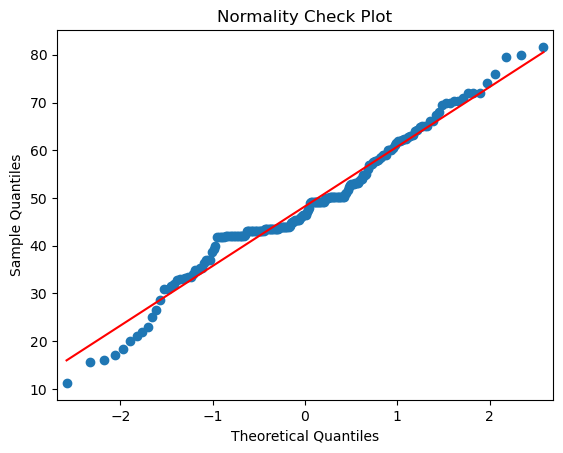

In [6]:
# Plot the qqplot to check for normality
qqplot(data_['Production'], line='s')
plt.title('Normality Check Plot');

b. Shapiro Wilk Test

The null hypothesis (H0) for the Shapiro-Wilk test is that the data is normally distributed in the population from which it is drawn. In other words, if the p-value obtained from the test is greater than a chosen significance level (e.g., 0.05), you fail to reject the null hypothesis, indicating that the data is normally distributed. If the p-value is less than the significance level, you reject the null hypothesis, suggesting that the data significantly deviates from a normal distribution.

In [7]:
# Select data for the test
data_shapiro = data_['Production']
# Perform Normality Test Using Shapiro Wilk Test
stat, p = shapiro(data_shapiro)
print('Statistics=%.6f, p=%.6f' % (stat, p))

# Interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian. Use Parametric Model. (fail to reject H0)')
else:
    print('Sample does not look Gaussian. Use Non Parametric Model (reject H0)')

Statistics=0.973401, p=0.000654
Sample does not look Gaussian. Use Non Parametric Model (reject H0)


##### Checking for Trends, Seasonality, Stationarity, Cyclicality, Autocorrelation
a. Trend

In [8]:
def load_data(data):
    # Load your time series data 
    df = pd.read_excel('Kenya.xlsx', parse_dates=['Month'], sheet_name=2, skiprows=1)
    data = df[['Production', 'Month']]
    return data

In [9]:
load_data('Kenya.xlsx')

,Production,Month
0,42.0,2009-01-01
1,42.0,2009-02-01
2,42.0,2009-03-01
3,42.0,2009-04-01
4,42.0,2009-05-01
...,...,...
199,62.0,2025-08-01
200,60.0,2025-09-01
201,72.0,2025-10-01
202,70.0,2025-11-01


In [10]:
# # Sort the DataFrame by date if it's not already sorted
# df.sort_values(by='Date', inplace=True)

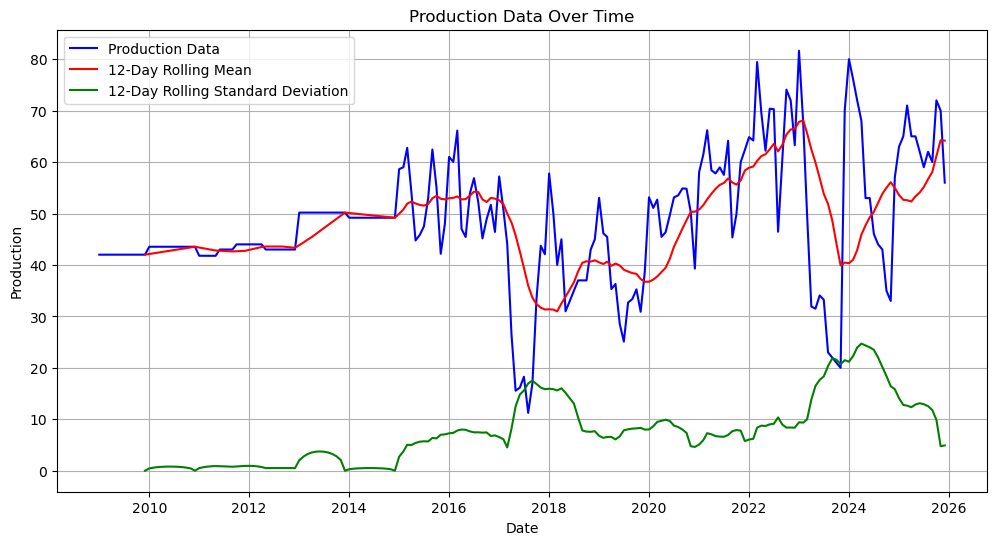

In [11]:
# Check for Trend
df = load_data('Kenya.xlsx')

# Plot the production data over time
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Production'], label='Production Data', color='blue')
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Production Data Over Time')
plt.grid(True)

# Check for trends using a rolling mean (moving average)
window_size = 12  # You can adjust this window size to suit your data
rolling_mean = df['Production'].rolling(window=window_size).mean()
rolling_std = df['Production'].rolling(window=window_size).std()
plt.plot(df['Month'], rolling_mean, label=f'{window_size}-Day Rolling Mean', color='red')
plt.plot(df['Month'], rolling_std, label=f'{window_size}-Day Rolling Standard Deviation', color='green')

plt.legend()
plt.show()


b. Checking for Seasonality

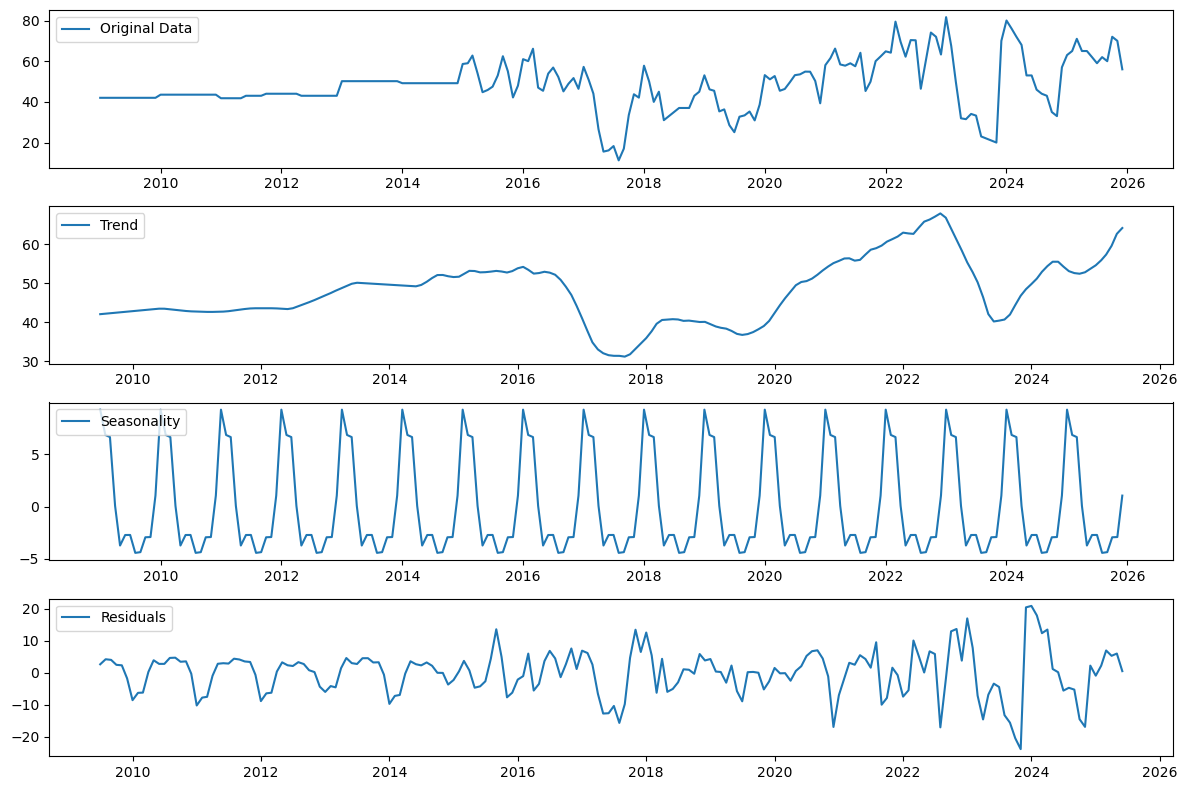

In [12]:
# Load your production data (replace 'your_data.csv' with your actual data file)
data = load_data('Kenya.xlsx')

# Assuming your date column is named 'Date' and your production column is named 'Production'
date_col = 'Month'
production_col = 'Production'

# Convert the 'Date' column to a datetime object
data[date_col] = pd.to_datetime(data[date_col])

# Set the 'Date' column as the index (required for seasonal decomposition)
data.set_index(date_col, inplace=True)

# Perform seasonal decomposition (additive model)
result = seasonal_decompose(data[production_col], model='additive', period=12)  # Assuming yearly seasonality

# Plot the original data, trend, seasonality, and residuals
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(data[production_col], label='Original Data')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


c:\Users\user\anaconda3\envs\wasokoenv\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


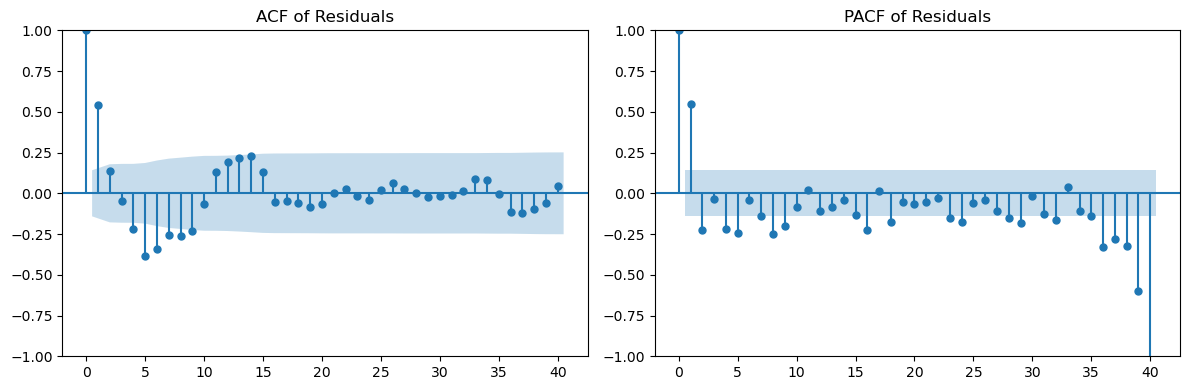

In [13]:
# Load your production data (replace 'your_data.csv' with your actual data file)
data = load_data('Kenya.xlsx')

# Assuming your date column is named 'Date' and your production column is named 'Production'
date_col = 'Month'
production_col = 'Production'

# Convert the 'Date' column to a datetime object
data[date_col] = pd.to_datetime(data[date_col])

# Set the 'Date' column as the index (required for seasonal decomposition)
data.set_index(date_col, inplace=True)

# Perform seasonal decomposition (additive model)
result = seasonal_decompose(data[production_col], model='additive', period=12)  # Assuming yearly seasonality

# Extract residuals
residuals = result.resid.dropna()

# Plot ACF and PACF of residuals
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(1, 2, 2)
plot_pacf(residuals, lags=40, ax=plt.gca())
plt.title('PACF of Residuals')

plt.tight_layout()
plt.show()


##### The Predictions

In [14]:
# Load the data
df = load_data('Kenya.xlsx')

# Prepare the data
df[['ds', 'y']] = df[['Month', 'Production']]
df = df.drop(['Month', 'Production'], axis=1, inplace=True)

# # Add a "cap" column for logistic growth
# df['cap'] = df['y'].max()  # Replace with the appropriate capacity value

# Create and fit the model
m = Prophet(changepoint_prior_scale=550, seasonality_prior_scale=10.0,
            changepoint_range=0.95,
            growth='linear') #, holidays=holiday_df

m.fit(df)

# Generate future dates
future = m.make_future_dataframe(periods=5*12, freq='M')  # Predicting for the next 5 years with monthly frequency

# Adjust the timestamp of future dates to the first day of the month
future['ds'] = pd.to_datetime(future['ds']).dt.to_period('M').dt.to_timestamp()

# Remove any duplicate dates in the future dataframe
future = future.drop_duplicates(subset=['ds'], keep='first')

# # Provide the capacity for future dates
# future['cap'] = df['y'].max()  # Replace with the appropriate capacity value

# Make predictions
forecast = m.predict(future)

# Apply a floor value to the predicted values
forecast['yhat'] = forecast['yhat']#.clip(lower=0)

# Concatenate actual and forecasted values
concat_df = pd.concat([df['ds'], df['y'], forecast['yhat']], axis=1)
concat_df.columns = ['ds', 'actual', 'predicted']

# Remove rows with missing values
concat_df = concat_df.dropna()

# Extract actual and predicted values
actual_values = concat_df['actual']
predicted_values = concat_df['predicted']

# Calculate RMSE
rmse = mean_squared_error(actual_values, predicted_values, squared=False)

# Calculate R-squared and adjusted R-squared
data = pd.concat([actual_values, predicted_values], axis=1)
data = sm.add_constant(data)
model = sm.OLS(data['actual'], data[['const', 'predicted']])
results = model.fit()
r_squared = results.rsquared
adj_r_squared = results.rsquared_adj

# Calculate MAPE
ape = abs((actual_values - predicted_values) / actual_values)
mape = ape.mean() * 100

# Display the forecasted values and evaluation metrics
print(concat_df.tail(30))
print('RMSE:', rmse)
print('R-squared:', r_squared)
print('Adjusted R-squared:', adj_r_squared)
print('MAPE:', mape)


AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [ ]:
# Load your time series data (assuming it's in a DataFrame with 'Date', 'Production', and 'Rainfall' columns)
# Replace 'your_data.csv' with your actual data file.
data = pd.read_csv('your_data.csv')

# Set the 'Date' column as the index and ensure it's in datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Assuming 'Production' and 'Rainfall' are the columns you want to forecast
production_data = data['Production']
rainfall_data = data['Rainfall']

# Define your ARIMA model
# You can experiment with different values for p, d, and q to find the best model for your data
p = 1  # Autoregressive order
d = 1  # Differencing order (to make the series stationary)
q = 1  # Moving average order

# Combine Production and Rainfall as predictors with a random walk component
predictors = pd.concat([production_data.shift(1), rainfall_data.shift(1)], axis=1)
predictors.columns = ['Production_Lag1', 'Rainfall_Lag1']
predictors = predictors[1:]

model = ARIMA(production_data[1:], order=(p, d, q), exog=predictors)

# Fit the model to your historical data
model_fit = model.fit(disp=0)

# Make forecasts for the next 4 years (48 months)
forecast_steps = 48
forecast_dates = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='M')

# Create lagged values of production and rainfall for forecasting
production_lag1 = production_data[-1]
rainfall_lag1 = rainfall_data[-1]

# Create lists to store the forecasted values
forecasted_production = []
forecasted_rainfall = []

# Perform the forecast step by step
for step in range(forecast_steps):
    # Forecast production for the current step
    forecasted_value = model_fit.forecast(steps=1, exog=np.array([[production_lag1, rainfall_lag1]]))
    forecasted_production.append(forecasted_value[0])

    # You can also update rainfall in a similar way, depending on your model
    
    # Update the lagged values for the next step
    production_lag1 = forecasted_value[0]
    # rainfall_lag1 = ...

# Create DataFrames for the forecasts
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Production_Forecast': forecasted_production,
    'Rainfall_Forecast': forecasted_rainfall
})

# Print or save the forecasted values
print(forecast_df)

# Plot the historical data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(production_data, label='Historical Production', color='blue')
plt.plot(forecast_dates, forecasted_production, label='Production Forecast', color='red')
plt.xlabel('Year')
plt.ylabel('Production')
plt.title('Production Forecast (2024-2027) with Rainfall')
plt.legend()
plt.grid(True)
plt.show()
